# Sieć neuronowa z 4 warstwami ukrytymi ReLU.

***Uczenie metodą SGD z momentum***

In [1]:
# +-----------------------------------------------------------------------+
# |          Sieć neuronowa z 4 warstwami ukrytymi neuronów (ReLU).       |
# +-----------------------------------------------------------------------+

import numpy as np
import matplotlib.pyplot as plt

In [2]:

# Funkcja do aproksymacji
Fun = lambda x: np.sin(2 * x[0, :] + x[1, :]) / np.exp(0.2 * x[1, :])

n_inputs = 2 # liczba wejść
n_hidden = (30, 30, 30, 30) # liczba neuronów w warstwach ukrytych
n_outputs = 1 # liczba wyjść

n_train = 9000 # liczba próbek uczących
n_val = 3000   # liczba próbek walidujących

# Generowanie próbek uczących i walidujących
X_min = 0; X_max = 10

X_train = np.random.uniform(X_min, X_max, (n_inputs, n_train))
Y_train = Fun(X_train)
X_train = (X_train - X_min) / (X_max - X_min)  # Przeskalowanie do [0, 1]

X_val = np.random.uniform(X_min, X_max, (n_inputs, n_val))
Y_val = Fun(X_val)
X_val = (X_val - X_min) / (X_max - X_min)  # Przeskalowanie do [0, 1]

In [3]:

# Wczytaj zapisane wagi modelu oraz poprzednie kierunki minimalizacji

data = np.load(f"weights_({n_hidden[0]},{n_hidden[1]},{n_hidden[2]},{n_hidden[3]})_hidden.npz")

b1 = data['b1']
W1 = data['W1']
b2 = data['b2']
W2 = data['W2']
b3 = data['b3']
W3 = data['W3']
b4 = data['b4']
W4 = data['W4']
b5 = data['b5']
W5 = data['W5']

p_b1_old = data['p_b1_old']
p_W1_old = data['p_W1_old']
p_b2_old = data['p_b2_old']
p_W2_old = data['p_W2_old']
p_b3_old = data['p_b3_old']
p_W3_old = data['p_W3_old']
p_b4_old = data['p_b4_old']
p_W4_old = data['p_W4_old']
p_b5_old = data['p_b5_old']
p_W5_old = data['p_W5_old']

# ----------------------------------------------

# # Losowa inicjalizacja wag i biasów

# b1 = np.random.uniform(-0.5, 0.5, (n_hidden[0], 1))
# W1 = np.random.uniform(-0.5, 0.5, (n_hidden[0], n_inputs))

# b2 = np.random.uniform(-0.5, 0.5, (n_hidden[1], 1))
# W2 = np.random.uniform(-0.5, 0.5, (n_hidden[1], n_hidden[0]))

# b3 = np.random.uniform(-0.5, 0.5, (n_hidden[2], 1))
# W3 = np.random.uniform(-0.5, 0.5, (n_hidden[2], n_hidden[1]))

# b4 = np.random.uniform(-0.5, 0.5, (n_hidden[3], 1))
# W4 = np.random.uniform(-0.5, 0.5, (n_hidden[3], n_hidden[2]))

# b5 = np.random.uniform(-0.5, 0.5, (n_outputs, 1))
# W5 = np.random.uniform(-0.5, 0.5, (n_outputs, n_hidden[3]))

# # zerowa inicjalizacja poprzedniego kierunku minimalizacji

# p_b1_old = np.zeros((n_hidden[0], 1))
# p_W1_old = np.zeros((n_hidden[0], n_inputs))

# p_b2_old = np.zeros((n_hidden[1], 1))
# p_W2_old = np.zeros((n_hidden[1], n_hidden[0]))

# p_b3_old = np.zeros((n_hidden[2], 1))
# p_W3_old = np.zeros((n_hidden[2], n_hidden[1]))

# p_b4_old = np.zeros((n_hidden[3], 1))
# p_W4_old = np.zeros((n_hidden[3], n_hidden[2]))

# p_b5_old = np.zeros((n_outputs, 1))
# p_W5_old = np.zeros((n_outputs, n_hidden[3]))

Epoka [10/10]  MSE train: 4.574681e-04  MSE val: 5.080588e-04

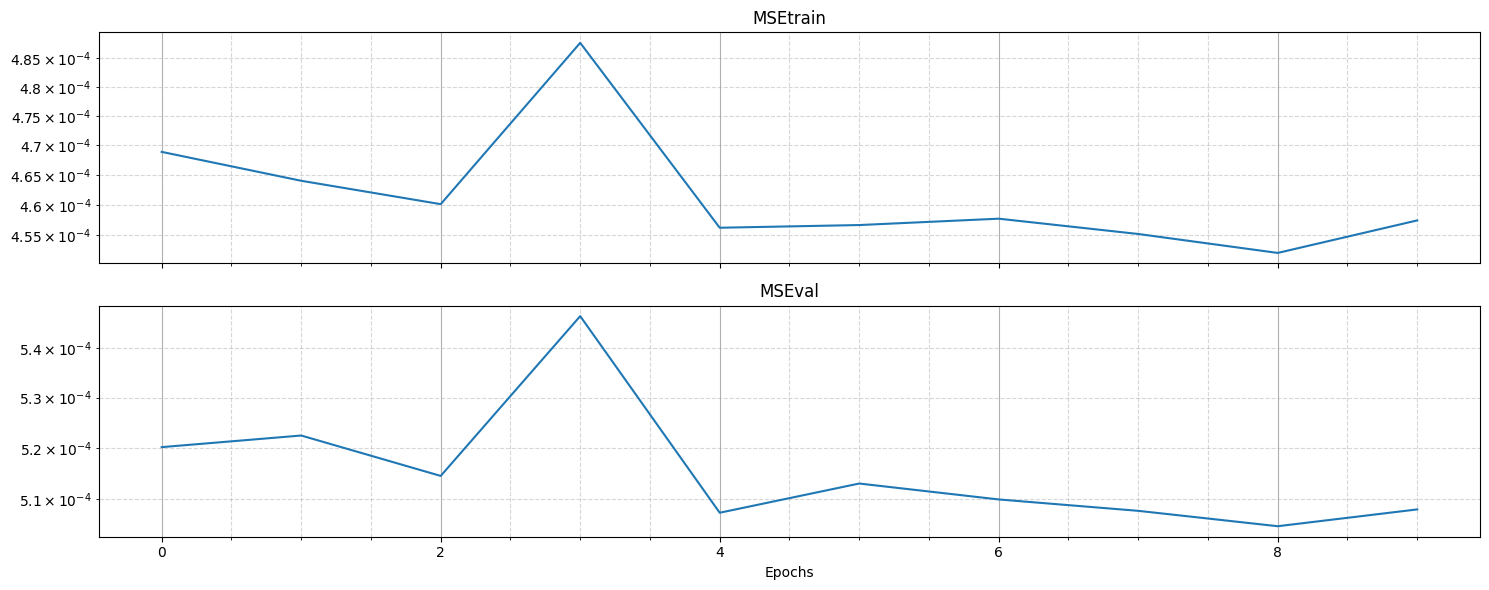

In [19]:

max_epochs = 10 # maksymalna liczba epok
learning_rate = 0.01 # współczynnik uczenia
momentum = 0.9 # współczynnik momentum
mb_size = 500 # rozmiar mini-batcha


# deklaracja potrzebnych tablic

idx = np.zeros((1, mb_size), dtype=int)
X = np.zeros((n_inputs, mb_size))
Y = np.zeros((n_outputs, mb_size))

# ---

Z1 = np.zeros((n_hidden[0], mb_size))
V1 = np.zeros((n_hidden[0], mb_size))

Z2 = np.zeros((n_hidden[1], mb_size))
V2 = np.zeros((n_hidden[1], mb_size))

Z3 = np.zeros((n_hidden[2], mb_size))
V3 = np.zeros((n_hidden[2], mb_size))

Z4 = np.zeros((n_hidden[3], mb_size))
V4 = np.zeros((n_hidden[3], mb_size))

Z5 = np.zeros((n_outputs, mb_size))
Y_hat = np.zeros((n_outputs, mb_size))

# ---

p_b1 = np.zeros((n_hidden[0], 1))
p_W1 = np.zeros((n_hidden[0], n_inputs))

p_b2 = np.zeros((n_hidden[1], 1))
p_W2 = np.zeros((n_hidden[1], n_hidden[0]))

p_b3 = np.zeros((n_hidden[2], 1))
p_W3 = np.zeros((n_hidden[2], n_hidden[1]))

p_b4 = np.zeros((n_hidden[3], 1))
p_W4 = np.zeros((n_hidden[3], n_hidden[2]))

p_b5 = np.zeros((n_outputs, 1))
p_W5 = np.zeros((n_outputs, n_hidden[3]))

# ---

dL5 = np.zeros((n_outputs, mb_size))
dL4 = np.zeros((n_hidden[3], mb_size))
dL3 = np.zeros((n_hidden[2], mb_size))
dL2 = np.zeros((n_hidden[1], mb_size))
dL1 = np.zeros((n_hidden[0], mb_size))

# ---

dE_db1 = np.zeros((n_hidden[0], 1))
dE_dW1 = np.zeros((n_hidden[0], n_inputs))

dE_db2 = np.zeros((n_hidden[1], 1))
dE_dW2 = np.zeros((n_hidden[1], n_hidden[0]))

dE_db3 = np.zeros((n_hidden[2], 1))
dE_dW3 = np.zeros((n_hidden[2], n_hidden[1]))

dE_db4 = np.zeros((n_hidden[3], 1))
dE_dW4 = np.zeros((n_hidden[3], n_hidden[2]))

dE_db5 = np.zeros((n_outputs, 1))
dE_dW5 = np.zeros((n_outputs, n_hidden[3]))

# ---

MSEtrainTab = np.zeros((max_epochs, 1))
MSEvalTab = np.zeros((max_epochs, 1))


# uczenie sieci metodą SGD+momentum

for i in range(max_epochs):
    for j in range(1000):
        idx = np.random.permutation(n_train)[:mb_size]
        X = X_train[:, idx]
        Y = Y_train[idx]

        # Forward pass
        Z1 = W1 @ X + b1
        V1 = np.maximum(0, Z1)
        Z2 = W2 @ V1 + b2
        V2 = np.maximum(0, Z2)
        Z3 = W3 @ V2 + b3
        V3 = np.maximum(0, Z3)
        Z4 = W4 @ V3 + b4
        V4 = np.maximum(0, Z4)
        Z5 = W5 @ V4 + b5
        Y_hat = Z5

        # Backward pass
        dL5 = 2 * (Y_hat - Y)
        dL4 = (W5.T @ dL5) * (Z4 > 0)
        dL3 = (W4.T @ dL4) * (Z3 > 0)
        dL2 = (W3.T @ dL3) * (Z2 > 0)
        dL1 = (W2.T @ dL2) * (Z1 > 0)

        # Gradienty
        dE_db5 = np.mean(dL5, axis=1, keepdims=True)
        dE_dW5 = (dL5 @ V4.T) / mb_size

        dE_db4 = np.mean(dL4, axis=1, keepdims=True)
        dE_dW4 = (dL4 @ V3.T) / mb_size

        dE_db3 = np.mean(dL3, axis=1, keepdims=True)
        dE_dW3 = (dL3 @ V2.T) / mb_size

        dE_db2 = np.mean(dL2, axis=1, keepdims=True)
        dE_dW2 = (dL2 @ V1.T) / mb_size

        dE_db1 = np.mean(dL1, axis=1, keepdims=True)
        dE_dW1 = (dL1 @ X.T) / mb_size

        # Aktualizacja kierunków
        p_b5 = (1 - momentum) * dE_db5 + momentum * p_b5_old
        p_W5 = (1 - momentum) * dE_dW5 + momentum * p_W5_old
        p_b4 = (1 - momentum) * dE_db4 + momentum * p_b4_old
        p_W4 = (1 - momentum) * dE_dW4 + momentum * p_W4_old
        p_b3 = (1 - momentum) * dE_db3 + momentum * p_b3_old
        p_W3 = (1 - momentum) * dE_dW3 + momentum * p_W3_old
        p_b2 = (1 - momentum) * dE_db2 + momentum * p_b2_old
        p_W2 = (1 - momentum) * dE_dW2 + momentum * p_W2_old
        p_b1 = (1 - momentum) * dE_db1 + momentum * p_b1_old
        p_W1 = (1 - momentum) * dE_dW1 + momentum * p_W1_old

        # Aktualizacja wag i biasów
        b5 -= learning_rate * p_b5
        W5 -= learning_rate * p_W5
        b4 -= learning_rate * p_b4
        W4 -= learning_rate * p_W4
        b3 -= learning_rate * p_b3
        W3 -= learning_rate * p_W3
        b2 -= learning_rate * p_b2
        W2 -= learning_rate * p_W2
        b1 -= learning_rate * p_b1
        W1 -= learning_rate * p_W1

        # Zapisanie poprzednich kierunków
        p_b5_old = p_b5
        p_W5_old = p_W5
        p_b4_old = p_b4
        p_W4_old = p_W4
        p_b3_old = p_b3
        p_W3_old = p_W3
        p_b2_old = p_b2
        p_W2_old = p_W2
        p_b1_old = p_b1
        p_W1_old = p_W1

    MSEtrain = np.mean((b5 + W5 @ np.maximum(0, b4 + W4 @ np.maximum(0, b3 + W3 @ np.maximum(0, b2 + W2 @ np.maximum(0, b1 + W1 @ X_train)))) - Y_train) ** 2)
    MSEval = np.mean((b5 + W5 @ np.maximum(0, b4 + W4 @ np.maximum(0, b3 + W3 @ np.maximum(0, b2 + W2 @ np.maximum(0, b1 + W1 @ X_val)))) - Y_val) ** 2)

    MSEtrainTab[i] = MSEtrain
    MSEvalTab[i] = MSEval

    print(f"\rEpoka [{i+1}/{max_epochs}]  MSE train: {MSEtrain:.6e}  MSE val: {MSEval:.6e}", end='')


# Wyświetlanie przebiegu uczenia

fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

ax1.plot(MSEtrainTab)
ax1.set_yscale('log')
ax1.set_title("MSEtrain")
ax1.minorticks_on()  # włącza dodatkowe podziałki
ax1.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax1.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

ax2.plot(MSEvalTab)
ax2.set_yscale('log')
ax2.set_title("MSEval")
ax2.set_xlabel("Epochs")
ax2.minorticks_on()  # włącza dodatkowe podziałki
ax2.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax2.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

plt.tight_layout() # ładniej wyglądają wykresy

In [20]:
# Zapisanie wyznaczonych wag modelu
np.savez(f"weights_({n_hidden[0]},{n_hidden[1]},{n_hidden[2]},{n_hidden[3]})_hidden.npz", 
    b1=b1, W1=W1, b2=b2, W2=W2, b3=b3, W3=W3, b4=b4, W4=W4, b5=b5, W5=W5,
    p_b1_old=p_b1_old, p_W1_old=p_W1_old, p_b2_old=p_b2_old, p_W2_old=p_W2_old, p_b3_old=p_b3_old, 
    p_W3_old=p_W3_old, p_b4_old=p_b4_old, p_W4_old=p_W4_old, p_b5_old=p_b5_old, p_W5_old=p_W5_old)


 MSE train:  5.072854e-04
 MSE val:    5.010241e-04

 AbsErr train:  1.688611e-02
 AbsErr val:    1.679519e-02


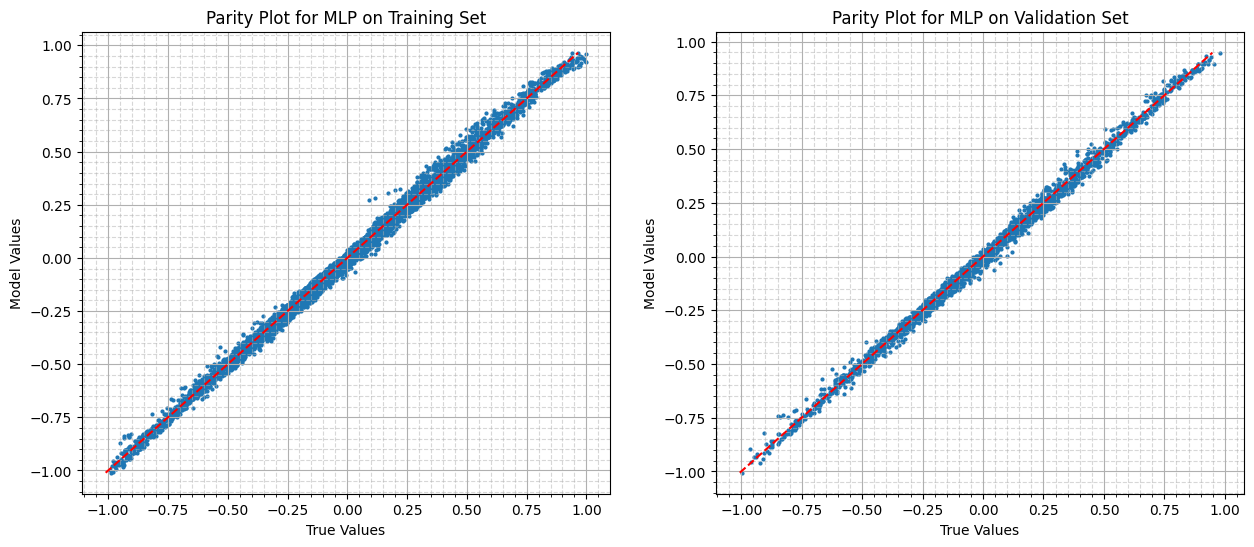

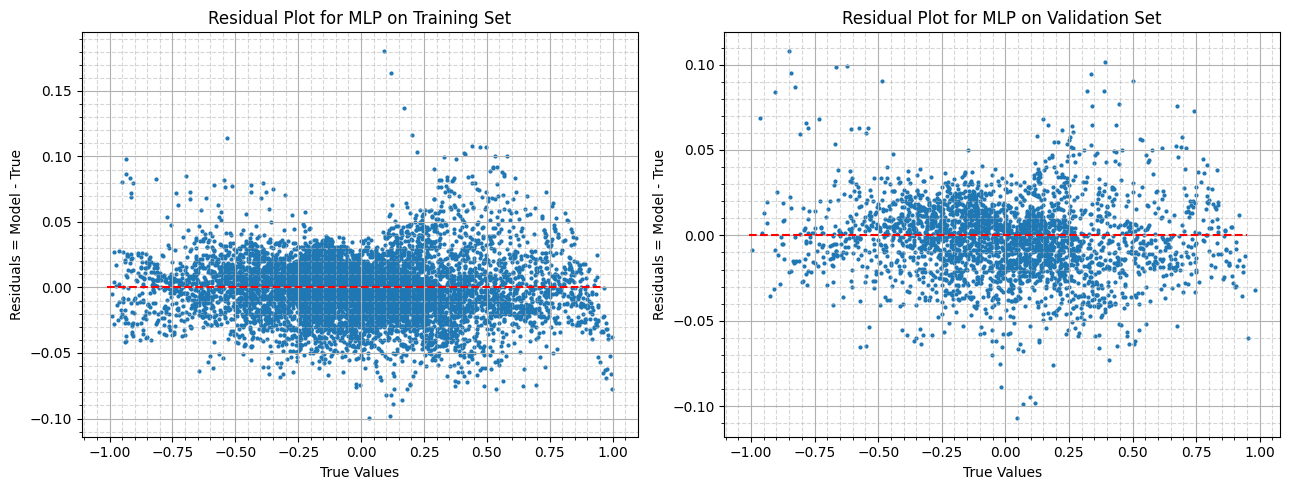

In [4]:

# --- Ocena modelu ---

Ymodel_train = b5 + W5 @ np.maximum(0, b4 + W4 @ np.maximum(0, b3 + W3 @ np.maximum(0, b2 + W2 @ np.maximum(0, b1 + W1 @ X_train))))
Ymodel_val = b5 + W5 @ np.maximum(0, b4 + W4 @ np.maximum(0, b3 + W3 @ np.maximum(0, b2 + W2 @ np.maximum(0, b1 + W1 @ X_val))))

MSEtrain = np.mean((Ymodel_train - Y_train) ** 2)
MSEval = np.mean((Ymodel_val - Y_val) ** 2)
print(f"\n MSE train:  {MSEtrain:.6e}\n MSE val:    {MSEval:.6e}")

ERRtrain = np.mean(np.abs(Ymodel_train - Y_train))
ERRval = np.mean(np.abs(Ymodel_val - Y_val))
print(f"\n AbsErr train:  {ERRtrain:.6e}\n AbsErr val:    {ERRval:.6e}")

#  --- Wykres dopasowania (prawdziwy Y) vs (przewidywany Y) ---

Ymodel_train_min = np.min(Ymodel_train)
Ymodel_train_max = np.max(Ymodel_train)
Ymodel_val_min = np.min(Ymodel_val)
Ymodel_val_max = np.max(Ymodel_val)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(Y_train, Ymodel_train, s=4)
ax1.plot([Ymodel_train_min, Ymodel_train_max], [Ymodel_train_min, Ymodel_train_max], 'r--')
ax1.set_title("Parity Plot for MLP on Training Set")
ax1.set_xlabel("True Values")
ax1.set_ylabel("Model Values")
ax1.minorticks_on()  # włącza dodatkowe podziałki
ax1.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax1.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

ax2.scatter(Y_val, Ymodel_val, s=4)
ax2.plot([Ymodel_val_min, Ymodel_val_max], [Ymodel_val_min, Ymodel_val_max], 'r--')
ax2.set_title("Parity Plot for MLP on Validation Set")
ax2.set_xlabel("True Values")
ax2.set_ylabel("Model Values")
ax2.minorticks_on()  # włącza dodatkowe podziałki
ax2.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax2.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

# --- Wykres residual plot ---

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.scatter(Y_train, Ymodel_train - Y_train, s=4)
ax1.plot([Ymodel_train_min, Ymodel_train_max], [0,0], 'r--')
ax1.set_title("Residual Plot for MLP on Training Set")
ax1.set_xlabel("True Values")
ax1.set_ylabel("Residuals = Model - True")
ax1.minorticks_on()  # włącza dodatkowe podziałki
ax1.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax1.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

ax2.scatter(Y_val, Ymodel_val - Y_val, s=4)
ax2.plot([Ymodel_val_min, Ymodel_val_max], [0,0], 'r--')
ax2.set_title("Residual Plot for MLP on Validation Set")
ax2.set_xlabel("True Values")
ax2.set_ylabel("Residuals = Model - True")
ax2.minorticks_on()  # włącza dodatkowe podziałki
ax2.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax2.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

plt.tight_layout() # ładniej wyglądają wykresy